# Matrix Factorization for Recommendations in Python

In this post, I'll detail a basic version of low-rank matrix factorization for recommendations employ it on a dataset of 1 million movie ratings (from 1 to 5) available from the [MovieLens](http://grouplens.org/datasets/movielens/) project. The MovieLens datasets were created collected by GroupLens Research at the University of Minnesota.

[Previously](https://beckernick.github.io/music_recommender/), I used item-based collaborative filtering to make music recommendations from raw artist listen-count data. I had a relatively small amount of data, and ended up making some pretty good recommendations. Collaborative filtering methods that compute distance relationships between items or users are generally thought of as "neighborhood" methods, since they center on the idea of "nearness". Unfortunately, there are two issues with taking this approach:

1. It doesn't scale particularly well to massive datasets
2. There's a theoretical concern with raw data based approaches.

I talked about the scaling issue in the previous post, but not the conceptual issue. The key concern is that ratings matrices may be overfit and noisy representations of user tastes and preferences. When we use distance based "neighborhood" approaches on raw data, we match to sparse low-level details that we assume represent the user's preference vector instead of the vector itself. It's a subtle difference, but it's important.

If I've listened to ten Red Hot Chili Peppers songs and you've listened to ten different Red Hot Chili Peppers songs, the raw user action matrix wouldn't have any overlap. We'd have nothing in common, even though it seems pretty likely we share at least some underlying preferencs.

If it sounds like using song features (such as genre) could help, you're right. But, to steal Joseph Konstan's (professor at Minnesota involved with GroupLens Research who has an awesome [Coursera course](https://www.coursera.org/specializations/recommender-systems) on Recommender Systems) example, what if we both like songs with great storytelling, regardless of the genre. So, how do we resolve this? I would need a method that can derive the tastes and preference vectors from the raw data.

Low-Rank Matrix Factorization is that kind of method.

# Matrix Factorization via Singular Value Decomposition

Matrix factorization is the breaking down of one matrix in a product of multiple matrices. It's extremely well studied in mathematics, and it's highly useful. There are many different ways to factor matrices, but singular value decomposition is particularly useful for making recommendations.

So what is singular value decomposition (SVD)? At a high level, SVD is an algorithm that decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where R is users's ratings matrix, $U$ is the user "features" matrix, $\Sigma$ is the diagonal matrix of singular values (essentially weights), and $V^{T}$ is the movie "features" matrix. $U$ and $V^{T}$ are orthogonal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, we take these matrices and keep only the top $k$ features, which we think of as the underlying tastes and preferences vectors.


# Setting Up the Ratings Data

Okay, enough with the math. Let's get to the code.

In [1]:
import pandas as pd
import numpy as np

ratings_list = [i.strip().split("::") for i in open('ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('ml-1m/movies.dat', 'r').readlines()]

In [2]:
ratings = np.array(ratings_list)
users = np.array(users_list)
movies = np.array(movies_list)

In [3]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

I'll also take a look at the movies and ratings dataframes.

In [4]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


These look good, but I want the format of my ratings matrix to be one row per user and one column per movie. I'll `pivot` `ratings_df` to get that and call the new variable `R`.

In [6]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The last thing I need to do is de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [21]:
R = R_df.values.astype(int)#.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

All set. With my ratings matrix properly formatted and normalized, I'm ready to do the singular value decomposition

# Singular Value Decomposition

Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function `svds` because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [22]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

Done. The function returns exactly what I detailed earlier in this post, except that the $\Sigma$ returned is just the values instead of a diagonal matrix. This is useful, but since I'm going to leverage matrix multiplication to get predictions I'll convert it to the diagonal matrix form.

In [23]:
sigma = np.diag(sigma)

# Making Predictions from the Decomposed Matrices

I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $R$.

I also need to add the user means back to get the actual star ratings prediction.

In [24]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

If I wanted to put this kind of system into production, I'd want to create a training and validation set and optimize the number of latent features ($k$) by minimizing the Root Mean Square Error. Intuitively, the Root Mean Square Error will decrease on the training set as $k$ increases (because I'm approximating the original ratings matrix with a higher rank matrix).

However, for movies, between around 20 and 100 feature "preferences" vectors have been found to be optimal for generalizing to unseen data.

I could create a training and validation set and optimize $k$ by minimizing RMSE, but since I'm just going through proof of concept I'll leave that for another post. I just want to see some movie recommendations.

# Making Movie Recommendations
Finally, it's time. With the predictions matrix for every user, I can build a function to recommend movies for any user. All I need to do is return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use actually use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

I'll also return the list of movies the user has already rated, for the sake of comparison.

In [25]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
0,4.288861,-0.195950,0.059791,0.013902,-0.005269,0.068531,0.034708,0.051772,0.019438,0.069625,...,0.015478,0.025567,-0.089656,0.045402,0.045417,0.058002,0.006646,0.036945,0.060534,0.050752
1,4.516912,0.942800,-0.185102,-0.070946,-0.031497,-0.132928,-0.088461,0.403236,-0.046937,0.974084,...,-0.207525,-0.057530,0.063368,-0.005378,-0.037052,-0.078082,0.059184,-0.114663,-0.153838,-0.273473
2,-0.078546,0.907657,-0.012436,-0.018223,-0.004993,-0.009990,0.088658,-0.079309,-0.001477,0.027198,...,-0.010521,-0.017129,0.103189,-0.007191,0.002086,0.283959,0.051613,0.024014,-0.001504,-0.027704
3,3.800371,0.528449,-0.124235,-0.016057,-0.000831,-0.207614,-0.140680,0.048933,-0.088665,0.111042,...,0.062178,-0.091779,-0.176755,-0.025442,-0.033945,-0.159619,-0.151297,-0.029600,0.087014,-0.181658
4,3.058320,0.926521,0.218438,0.169113,0.168728,0.271766,0.031149,0.133045,0.314324,-0.391314,...,0.126222,0.073419,1.065916,0.208309,0.302333,1.883380,-0.141761,0.350303,0.240005,0.596033


In [27]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )

    print ( 'User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]) )
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations) )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [28]:
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)

User 837 has already rated 0 movies.
Recommending highest 10 predicted ratings movies not already rated.


ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

So, how'd I do?

In [29]:
already_rated.head(10)

NameError: name 'already_rated' is not defined

In [258]:
predictions

,MovieID,Title,Genres
516,527,Schindler's List (1993),Drama|War
1848,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
596,608,Fargo (1996),Crime|Drama|Thriller
1235,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2085,2194,"Untouchables, The (1987)",Action|Crime|Drama
1188,1230,Annie Hall (1977),Comedy|Romance
1198,1242,Glory (1989),Action|Drama|War
897,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1849,1954,Rocky (1976),Action|Drama
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller


Pretty cool! These look like pretty good recommendations. It's also good to see that, though I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some film-noirs, crime, drama, and war movies - all of which were genres of some of this user's top rated movies.

# Conclusion

We've seen that we can make good recommendations with raw data based collaborative filtering methods (neighborhood models) and latent features from low-rank matrix factorization methods (factorization models).

Low-dimensional matrix recommenders try to capture the underlying features driving the raw data (which we understand as tastes and preferences). From a theoretical perspective, if we want to make recommendations based on people's tastes, this seems like the better approach. This technique also scales **significantly** better to larger datasets.

However, we still likely lose some meaningful signals by using a lower-rank matrix. And though these factorization based techniques work extremely well, there's research being done on new methods. These efforts have resulted in various types probabilistic matrix factorization (which works and scales even better) and many other approaches.

One particularly cool and effective strategy is to combine factorization and neighborhood methods into one [framework](http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf). This research field is extremely active, and I highly recommend Joseph Konstan's Coursera course, [Introduction to Recommender Systems](https://www.coursera.org/specializations/recommender-systems), for anyone looking to get a high level overview of the field. The optional readings are influential papers in the field from the last 15-ish years, and they're really cool.

***
For those interested, the Jupyter Notebook with all the code can be found in the [Github repository](https://github.com/beckernick/matrix_factorization_recommenders) for this post.

# MovieLens Datasets

In [30]:
import numpy as np
import pandas as pd

In [31]:
ratings_list = [i.strip().split("::") for i in open('ml-1m/ratings.dat', 'r').readlines()]

In [33]:
len(ratings_list)

1000209

In [299]:
ratings = np.array(ratings_list)

In [35]:
ratings[0]

array(['1', '1193', '5', '978300760'], dtype='<U10')

In [300]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)

In [37]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [301]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating')
#.fillna(0)
#R_df.head()

In [302]:
R_df.shape

(6040, 3706)

In [41]:
R_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
users=R_df.index
items=R_df.columns

In [53]:
len(users),len(items)

(6040, 3706)

In [165]:
def list_users_items(R):
    list_users=[]
    for u in users:
        lu=R.loc[u,:][R.loc[u,:].notnull()].index.tolist()
        list_users.append(lu)
    list_items=[]
    for i in items:
        li=R.loc[:,i][R.loc[:,i].notnull()].index.tolist()
        list_items.append(li)
    return (list_items,list_users)

In [119]:
lusers,litems=list_users_items(R_df)

In [303]:
R=R_df.fillna(0)

In [304]:
R=R.values.astype(int)

In [306]:
R.shape

(6040, 3706)

In [307]:
R=csr_matrix(R)

In [82]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [89]:
len(ratings_df[ratings_df['UserID']==users[0]])

53

In [93]:
R_df.loc[users[0],list_c[0][1]]

nan

In [94]:
len(ratings_df)

1000209

In [95]:
np.sum(R_df.count())

1000209

In [110]:
R_df.loc[users[0],:][R_df.loc[users[0],:].notnull()].index.tolist()

53

# Recommendation systems Chapter 9

In [ ]:
df=pd.read_csv('sample.csv')

In [132]:
df.head()

,Users,Items,Ratings
0,A,HP1,4
1,A,TW,5
2,A,SW1,1
3,B,HP1,5
4,B,HP2,5


In [130]:
users=df['Users'].unique()
items=df['Items'].unique()

In [133]:
R_df = df.pivot(index = 'Users', columns ='Items', values = 'Ratings')

In [206]:
R_df

Items,HP1,HP2,HP3,SW1,SW2,SW3,TW
Users,,,,,,,
A,4.0,NaN,NaN,1.0,NaN,NaN,5.0
B,5.0,5.0,4.0,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,4.0,5.0,NaN,2.0
D,NaN,3.0,NaN,NaN,NaN,3.0,NaN


In [181]:
lusers,litems=list_users_items(R_df)

In [208]:
R=R_df.fillna(0).values.astype(int)

In [183]:
R

array([[4, 0, 0, 1, 0, 0, 5],
       [5, 5, 4, 0, 0, 0, 0],
       [0, 0, 0, 4, 5, 0, 2],
       [0, 3, 0, 0, 0, 3, 0]])

In [213]:
a=np.argwhere(R!=0.0)

In [216]:
b=pd.DataFrame(a,columns=['r','c'])

In [254]:
from scipy.sparse import csr_matrix

In [256]:
R=csr_matrix(R)

In [258]:
print(R)

  (0, 0)	4
  (0, 3)	1
  (0, 6)	5
  (1, 0)	5
  (1, 1)	5
  (1, 2)	4
  (2, 3)	4
  (2, 4)	5
  (2, 6)	2
  (3, 1)	3
  (3, 5)	3


In [186]:
(n,m)=R.shape# (4,7)

In [188]:
k=2

In [223]:
def non_zero_position(R):
    a=np.argwhere(R!=0.0)
    b=pd.DataFrame(a,columns=['r','c'])
    return b

In [189]:
#assigning random matrices for P and Q
P = np.random.rand(n,k) 
Q = np.random.rand(m,k)

In [193]:
P

array([[0.17108993, 0.51148512],
       [0.84422992, 0.95349846],
       [0.6238753 , 0.54481405],
       [0.52496509, 0.63799384]])

In [194]:
Q

array([[0.5664762 , 0.23732289],
       [0.13455253, 0.38608071],
       [0.49201048, 0.03309668],
       [0.19358059, 0.40176146],
       [0.43032465, 0.22255107],
       [0.7847085 , 0.58195609],
       [0.05113769, 0.10036635]])

In [195]:
from numpy.linalg import solve

In [202]:
a = np.dot(P.T,P)
b = np.dot(Q.T,Q)
#x = solve(a, b)

In [245]:
def error_rmse(R,U,V):
    a=np.argwhere(R!=0.0)
    Rhat=np.dot(U,V.T)
    error=[]
    for k in range(len(a)):
        i=a[k,0]
        j=a[k,1]
        e=R[i,j]-Rhat[i,j]
        error.append(e)
    return np.square(error).mean()  

In [238]:
er=error_rmse(R,P,Q)

In [270]:
def rmse(util_mtx, u, v):
    e = 0.
    m = 0.
    r,c = util_mtx.shape
    for i in range(r):
        for j in util_mtx[i].indices:
            e += (util_mtx[i,j]-np.dot(v[j], u[i]))**2
            m+=1
    return np.sqrt(e/m)

In [308]:
def sgd_uv(util_mtx, f=2, lr=0.01, reg=0.1, max_iter=1000):
    #get dimensions of util_mtx, which is a compressed sparse row matrix
    r,c = util_mtx.shape
    #initialize item matrix
    v = np.random.rand(c,f)
    #initialize user matrix
    u = np.random.rand(r,f)
    #fit the matrices with a fixed number of iterations
    error=[]
    for c in range(max_iter):
        for i in range(r):
            for j in util_mtx[i].indices:
                err = util_mtx[i,j] - np.dot(v[j], u[i])
                v[j] = v[j] + lr*(err*u[i]-reg*v[j])
                u[i] = u[i] + lr*(err*v[j]-reg*u[i])
        er=rmse(util_mtx,u,v)
        error.append(er)
    return u,v,error

In [309]:
U,V,E=sgd_uv(R,f=2)

KeyboardInterrupt: 

In [281]:
rmse(R,U,V)

0.12312376061918161

In [288]:
#print(f'{val:.2f}')
print(np.dot(U,V.T) )

[[3.92851351 3.43918952 2.70396388 1.03328456 3.20610753 3.43506578
  4.78514188]
 [4.88037125 4.83380751 3.92727481 3.41331172 5.48789897 4.63712103
  4.30721832]
 [3.4703285  3.80236223 3.16219174 3.81250158 4.88132425 3.53788882
  1.99766874]
 [3.0258438  2.98485283 2.42265245 2.07027415 3.37001397 2.86704334
  2.70584452]]


In [275]:
import matplotlib.pyplot as plt
%matplotlib inline

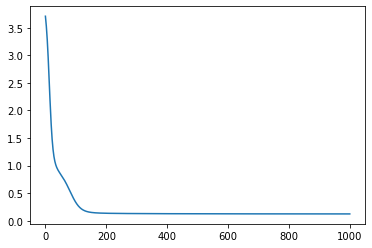

In [280]:
plt.plot(E)
plt.show()

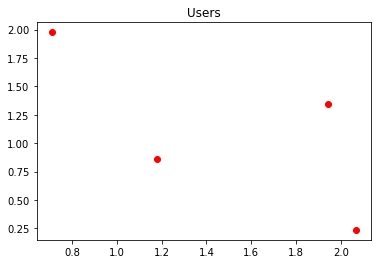

In [293]:
plt.title('Users')
plt.plot(U[:,0],U[:,1],'ro')
plt.show()

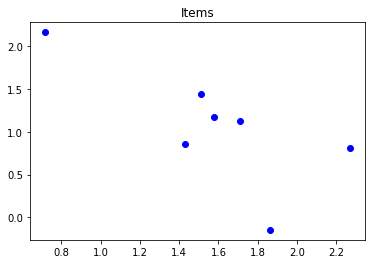

In [294]:
plt.title('Items')
plt.plot(V[:,0],V[:,1],'bo')
plt.show()

# Ratings_df Timestamp

In [14]:
ratings_df['Timestamp']=pd.to_datetime(ratings_df['Timestamp'], unit='s')
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [6]:
df=ratings_df.head()

In [7]:
df['Timestamp']

0    978300760
1    978302109
2    978301968
3    978300275
4    978824291
Name: Timestamp, dtype: object

In [12]:
ratings_df['Timestamp']=pd.to_datetime(ratings_df['Timestamp'], unit='s')

In [13]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [24]:
users=ratings_df['UserID'].unique()
count_movie=[]
for u in users:
    m=len(ratings_df[ratings_df['UserID']==u] )
    count_movie.append(m)